In [1]:
import os
import shutil
import numpy as np
from PIL import Image

Load the masked original and inpainted images from the mask_image folder. Please do this step once you have ran the preprocessing_and_eda notebook


In [2]:
def load_image_paths_from_folder(folder, label):
    image_paths = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith((".png", ".jpg", ".jpeg")):
            img_path = os.path.join(folder, filename)
            image_paths.append(img_path)
            labels.append(label)
    return image_paths, labels

# Load real image paths (label = 1)
# real_folder = "extracted_images/original"
real_folder = "mask_images/original"
real_image_paths, real_labels = load_image_paths_from_folder(real_folder, label=1)

# Load fake image paths (label = 0)
# fake_folder = "extracted_images/inpainting"
fake_folder = "mask_images/inpainting"
fake_image_paths, fake_labels = load_image_paths_from_folder(fake_folder, label=0)

# Combine real and fake image paths and labels
image_paths = real_image_paths + fake_image_paths
labels = real_labels + fake_labels

# Convert labels to NumPy array
labels = np.array(labels)

# Check number of images loaded
print(f"Number of real images: {len(real_image_paths)}")
print(f"Number of fake images: {len(fake_image_paths)}")
print(f"Total number of images: {len(image_paths)}")

# Function to load and preprocess images (to be used when training the model)
def load_and_preprocess_image(image_path, target_size=(256, 256), preserve_texture=True):
    img = Image.open(image_path)
    img = img.convert('RGB')  # Convert to RGB
    if preserve_texture:
        # Convert to numpy array for OpenCV processing
        img_array = np.array(img)
        
        # Use Lanczos resampling which better preserves high-frequency details
        img_array = cv2.resize(
            img_array, 
            target_size, 
            interpolation=cv2.INTER_LANCZOS4
        )
    else:
        img = img.resize(target_size)  # Resize the image
        img_array = np.array(img)

    img_array = img_array.astype(np.float32)
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array

Number of real images: 10013
Number of fake images: 10013
Total number of images: 20026


In [3]:
from numpy import random
import cv2
# Test the preprocessing function
test_image_path = random.choice(image_paths)  # Choose a random image
processed_image = load_and_preprocess_image(test_image_path)
# print(test_image_path)
# print(processed_image)

print(f"Processed image shape: {processed_image.shape}")
print(f"Min pixel value: {processed_image.min()}")
print(f"Max pixel value: {processed_image.max()}")
print(f"Mean pixel value: {processed_image.mean()}")

Processed image shape: (256, 256, 3)
Min pixel value: 0.0
Max pixel value: 0.9882352948188782
Mean pixel value: 0.22564004361629486


Train Test split

In [4]:
from sklearn.model_selection import train_test_split
# Perform train-test split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Print the shapes of the resulting datasets
print("\nAfter train-test split:")
print(f"Train set size: {len(train_paths)}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test set size: {len(test_paths)}")
print(f"Test labels shape: {test_labels.shape}")

# Print the distribution of labels in train and test sets
print(f"\nTrain set - Real: {np.sum(train_labels == 1)}, Fake: {np.sum(train_labels == 0)}")
print(f"Test set - Real: {np.sum(test_labels == 1)}, Fake: {np.sum(test_labels == 0)}")


After train-test split:
Train set size: 16020
Train labels shape: (16020,)
Test set size: 4006
Test labels shape: (4006,)

Train set - Real: 8010, Fake: 8010
Test set - Real: 2003, Fake: 2003


Initialize the CNN model

In [6]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2

In [ ]:
def improved_deepfake_detection_model(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    
    # Convolutional layers 1
    x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Convolutional layers 2
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Convolutional layers 3
    x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Convolutional layers 4
    x = Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)
    
    # Dense layers
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    # Final layer
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the model
model = improved_deepfake_detection_model()

# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496 

In [ ]:
from tensorflow.keras.optimizers import Adam


model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy', 'AUC'])
# train_gen = ImageDataGenerator(  preprocessing_function=lambda x: x / 255.0  # Normalize pixel values
# )

train_gen = ImageDataGenerator(
    rotation_range=5,    
    width_shift_range=0.1,     
    height_shift_range=0.1,
    horizontal_flip=False,  
    zoom_range=0.1,
    shear_range=0.0, 
    fill_mode='constant',  
    cval=0,                   # Black padding for constant fill mode
)
test_gen = ImageDataGenerator()

# Custom generator function
def custom_generator(features, labels, batch_size, gen, is_training=False, target_size=(256, 256)):
    while True:
        batch_indices = np.random.choice(len(features), batch_size)
        batch_features = np.array([load_and_preprocess_image(features[i], target_size) for i in batch_indices])
        batch_labels = labels[batch_indices]
        
        # Apply data augmentation only for training generator
        if is_training:
            batch_features, batch_labels = next(gen.flow(batch_features, batch_labels, batch_size=batch_size))
        
        yield batch_features, batch_labels

# Create generators
train_generator = custom_generator(train_paths, train_labels, batch_size=16, gen=train_gen, is_training=True, target_size=(256, 256))
test_generator = custom_generator(test_paths, test_labels, batch_size=16, gen=test_gen, is_training=False, target_size=(256, 256))

In [ ]:
# Test the custom generator
train_generator = custom_generator(train_paths, train_labels, batch_size=16, gen=train_gen, is_training=True, target_size=(256, 256))
test_generator = custom_generator(test_paths, test_labels, batch_size=16, gen=test_gen, is_training=False, target_size=(256, 256))

# Check a batch from each generator
train_batch_x, train_batch_y = next(train_generator)
test_batch_x, test_batch_y = next(test_generator)

print("Training batch:")
print(f"X shape: {train_batch_x.shape}, Y shape: {train_batch_y.shape}")
print(f"X min: {train_batch_x.min()}, X max: {train_batch_x.max()}, X mean: {train_batch_x.mean()}")
print(f"Y values: {np.unique(train_batch_y)}")

print("\nTesting batch:")
print(f"X shape: {test_batch_x.shape}, Y shape: {test_batch_y.shape}")
print(f"X min: {test_batch_x.min()}, X max: {test_batch_x.max()}, X mean: {test_batch_x.mean()}")
print(f"Y values: {np.unique(test_batch_y)}")

Training batch:
X shape: (32, 256, 256, 3), Y shape: (32,)
X min: 0.0, X max: 1.0, X mean: 0.2070801854133606
Y values: [0 1]

Testing batch:
X shape: (32, 256, 256, 3), Y shape: (32,)
X min: 0.0, X max: 1.0, X mean: 0.2344072312116623
Y values: [0 1]


In [12]:
import tensorflow as tf

class GradientCheck(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        weights = self.model.get_weights()
        has_nan = any(np.isnan(w).any() for w in weights)
        has_inf = any(np.isinf(w).any() for w in weights)
        print(f"Epoch {epoch+1}: NaN in weights: {has_nan}, Inf in weights: {has_inf}")

class LayerOutputCheck(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Get the output of the last layer (which should be the sigmoid output)
        layer_output = tf.keras.backend.function([self.model.input], [self.model.output])
        sample_data, sample_labels = next(train_generator)  # Get a batch of data and labels
        output = layer_output([sample_data])[0]
        
        # Calculate accuracy on this batch
        predicted_classes = (output > 0.5).astype(int)
        accuracy = np.mean(predicted_classes == sample_labels)
        
        print(f"Epoch {epoch+1}: Output range: {output.min():.4f} to {output.max():.4f}, Mean: {output.mean():.4f}")
        print(f"Batch accuracy: {accuracy:.4f}")
        print(f"Output distribution: {np.sum(output < 0.1)} < 0.1, {np.sum((output >= 0.1) & (output < 0.9))} in [0.1, 0.9), {np.sum(output >= 0.9)} >= 0.9")

class PrintProgress(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}: loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")

Train the CNN model

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

# Create a directory to save model weights if it doesn't exist
weights_dir = "model_weights"
os.makedirs(weights_dir, exist_ok=True)

# Define the file path for saving the model weights
checkpoint_filepath = os.path.join(weights_dir, "model_weights_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.weights.h5")

# Create a ModelCheckpoint callback to save the best model weights
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Save only weights, not the entire model
    save_best_only=True,  # Only save the best model
    monitor='val_loss',  # Metric to monitor
    mode='min',  # 'min' for loss, 'max' for accuracy
    verbose=1
)

# Create an EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,
    verbose=1
)

# Create a ReduceLROnPlateau callback to reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,  # Factor by which the learning rate will be reduced
    patience=2,  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,  # Lower bound on the learning rate
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_paths) // 32,
    epochs=25,
    validation_data=test_generator,
    validation_steps=len(test_paths) // 32,
    callbacks=[model_checkpoint_callback, early_stopping, reduce_lr, GradientCheck(), LayerOutputCheck(), PrintProgress()]
)

# Save the final model weights
final_weights_path = os.path.join(weights_dir, "final_model_weights.weights.h5")
model.save_weights(final_weights_path)
print(f"Final model weights saved to {final_weights_path}")

Epoch 1/25
253/253 [==============================] - ETA: 0s - loss: 0.9492 - accuracy: 0.6020
Epoch 1: val_loss improved from inf to 1.80840, saving model to model_weights\model_weights_epoch_01_val_loss_1.81.weights.h5
Epoch 1: NaN in weights: False, Inf in weights: False
Epoch 1: Output range: 0.0054 to 0.1181, Mean: 0.0357
Batch accuracy: 0.4062
Output distribution: 31 < 0.1, 1 in [0.1, 0.9), 0 >= 0.9
Epoch 1: loss: 0.9492 - accuracy: 0.6020 - val_loss: 1.8084 - val_accuracy: 0.4901
253/253 [==============================] - 334s 1s/step - loss: 0.9492 - accuracy: 0.6020 - val_loss: 1.8084 - val_accuracy: 0.4901 - lr: 2.5000e-04
Epoch 2/25
253/253 [==============================] - ETA: 0s - loss: 0.8474 - accuracy: 0.6459
Epoch 2: val_loss improved from 1.80840 to 1.59836, saving model to model_weights\model_weights_epoch_02_val_loss_1.60.weights.h5
Epoch 2: NaN in weights: False, Inf in weights: False
Epoch 2: Output range: 0.0021 to 0.8098, Mean: 0.0699
Batch accuracy: 0.6094
O

Load the CNN weights that have the lowest validation loss and test its performance

In [20]:
model = improved_deepfake_detection_model()  # Your model definition function
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00025), metrics=['accuracy'])
path_to_weight = 'model_weights_epoch_04_val_loss_0.57.weights.h5'
model.load_weights(f'model_weights_cnn/{path_to_weight}')

In [22]:
def test_generator(image_paths, labels, batch_size=32):
    num_samples = len(image_paths)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_paths = image_paths[offset:offset+batch_size]
            batch_labels = labels[offset:offset+batch_size]
            
            batch_images = np.array([load_and_preprocess_image(path) for path in batch_paths])
            
            yield batch_images, batch_labels

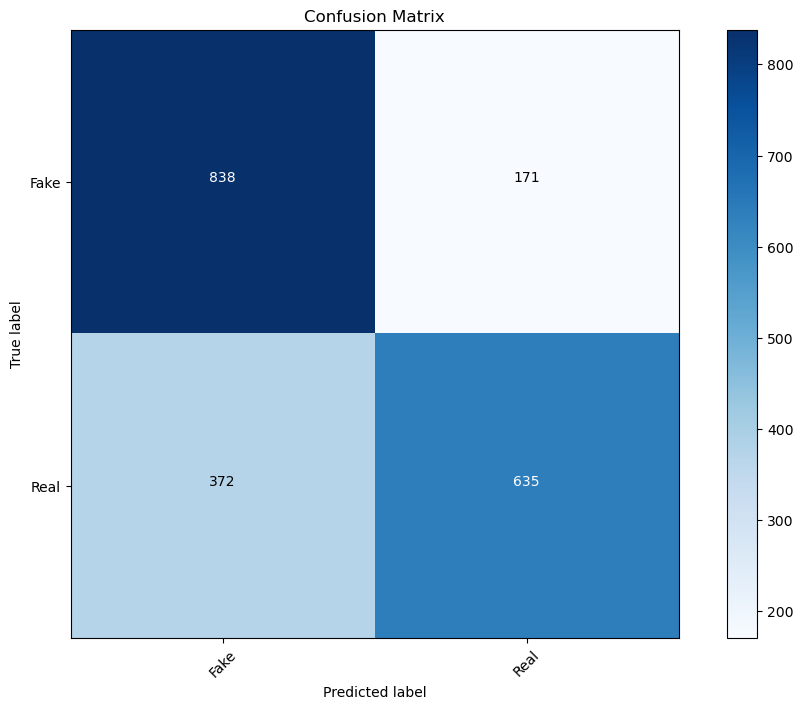


Classification Report:
              precision    recall  f1-score   support

        Fake       0.69      0.83      0.76      1009
        Real       0.79      0.63      0.70      1007

    accuracy                           0.73      2016
   macro avg       0.74      0.73      0.73      2016
weighted avg       0.74      0.73      0.73      2016


Accuracy: 0.7307
AUC-ROC: 0.8085


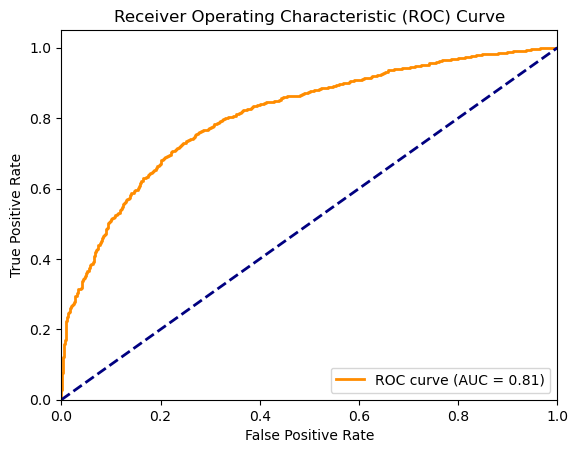

In [23]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve

# Function to get predictions and true labels
def get_predictions_and_labels(generator, num_samples, batch_size):
    steps = num_samples // batch_size
    y_pred = []
    y_true = []
    for _ in range(steps):
        batch_x, batch_y = next(generator)
        batch_pred = model.predict(batch_x, verbose=0)
        y_pred.extend(batch_pred)
        y_true.extend(batch_y)
    return np.array(y_pred).flatten(), np.array(y_true)

# Create the test generator
test_gen = test_generator(test_paths, test_labels, batch_size=32)

# Get predictions and true labels
num_test_samples = len(test_paths)
y_pred, y_true = get_predictions_and_labels(test_gen, num_test_samples, batch_size=32)

# Convert predictions to classes
y_pred_classes = (y_pred > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Fake', 'Real'], rotation=45)
plt.yticks(tick_marks, ['Fake', 'Real'])

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['Fake', 'Real']))

# Print accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"\nAccuracy: {accuracy:.4f}")

# Print AUC-ROC
auc_roc = roc_auc_score(y_true, y_pred)
print(f"AUC-ROC: {auc_roc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [29]:
def get_mask_type_for_images_v3(image_paths):
    """Improved mask type detection with proper diagonal categorization"""
    mask_types = []
    
    # Define specific patterns to look for
    diagonal_patterns = [
        'diagonal_top_left',
        'diagonal_top_right',
        'diagonal_bottom_left',
        'diagonal_bottom_right'
    ]
    
    basic_patterns = ['top', 'bottom', 'left', 'right', 'random']
    
    for path in image_paths:
        filename = os.path.basename(path)
        
        # First check for diagonal patterns (more specific)
        found_diagonal = False
        for pattern in diagonal_patterns:
            if pattern in filename:
                mask_types.append(pattern)
                found_diagonal = True
                break
                
        if not found_diagonal:
            # Then check for basic patterns
            found_basic = False
            for pattern in basic_patterns:
                if filename.startswith(f"{pattern}_"):
                    mask_types.append(pattern)
                    found_basic = True
                    break
                    
            if not found_basic:
                mask_types.append('random')
    
    # Print distribution
    total_images = len(image_paths)
    all_patterns = diagonal_patterns + basic_patterns
    
    print("\nMask Type Distribution:")
    print(f"Total images: {total_images}")
    for pattern in all_patterns:
        count = mask_types.count(pattern)
        percentage = (count / total_images) * 100
        print(f"{pattern}: {count} images ({percentage:.1f}%)")
    
    return mask_types


Mask Type Distribution:
Total images: 2026
diagonal_top_left: 212 images (10.5%)
diagonal_top_right: 236 images (11.6%)
diagonal_bottom_left: 291 images (14.4%)
diagonal_bottom_right: 293 images (14.5%)
top: 152 images (7.5%)
bottom: 245 images (12.1%)
left: 101 images (5.0%)
right: 103 images (5.1%)
random: 393 images (19.4%)


In [38]:
def plot_mask_type_results(results):
    """
    Create visualizations for mask-wise performance with sorted data
    """
    # Convert results to sorted lists
    # Sort by accuracy for first plot
    sorted_by_accuracy = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
    mask_types_acc = [item[0] for item in sorted_by_accuracy]
    accuracies = [results[mask]['accuracy'] for mask in mask_types_acc]
    auc_rocs = [results[mask]['auc_roc'] for mask in mask_types_acc]
    
    # Sort by number of samples for second plot
    sorted_by_samples = sorted(results.items(), key=lambda x: x[1]['num_samples'], reverse=True)
    mask_types_samples = [item[0] for item in sorted_by_samples]
    sample_counts = [results[mask]['num_samples'] for mask in mask_types_samples]
    
    # Plot accuracy and AUC-ROC comparison
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    x = np.arange(len(mask_types_acc))
    width = 0.35
    
    # Performance metrics plot (sorted by accuracy)
    bars1 = ax1.bar(x - width/2, accuracies, width, label='Accuracy', color='skyblue')
    bars2 = ax1.bar(x + width/2, auc_rocs, width, label='AUC-ROC', color='lightcoral')
    
    ax1.set_xlabel('Mask Type')
    ax1.set_ylabel('Score')
    ax1.set_title('Model Performance by Mask Type (Sorted by Accuracy)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(mask_types_acc, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on the bars
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom')
    
    add_value_labels(bars1)
    add_value_labels(bars2)
    
    # Sample distribution plot (sorted by sample count)
    ax2.bar(mask_types_samples, sample_counts, color='lightgreen')
    ax2.set_xlabel('Mask Type')
    ax2.set_ylabel('Number of Samples')
    ax2.set_title('Sample Distribution Across Mask Types (Sorted by Sample Count)')
    ax2.set_xticklabels(mask_types_samples, rotation=45, ha='right')
    
    # Add value labels on the bars
    for i, v in enumerate(sample_counts):
        ax2.text(i, v, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Plot confusion matrices for each mask type (sorted by accuracy)
    num_masks = len(mask_types_acc)
    fig_rows = (num_masks + 2) // 3  # Calculate number of rows needed
    plt.figure(figsize=(15, 5 * fig_rows))
    
    for idx, mask_type in enumerate(mask_types_acc, 1):
        cm = results[mask_type]['confusion_matrix']
        plt.subplot(fig_rows, 3, idx)
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(f'{mask_type}\n(n={results[mask_type]["num_samples"]})')
        
        plt.xticks([0, 1], ['Fake', 'Real'], rotation=45)
        plt.yticks([0, 1], ['Fake', 'Real'])
        
        # Add text annotations
        thresh = cm.max() / 2
        for i, j in np.ndindex(cm.shape):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.show()


Mask Type Distribution:
Total images: 2026
diagonal_top_left: 212 images (10.5%)
diagonal_top_right: 236 images (11.6%)
diagonal_bottom_left: 291 images (14.4%)
diagonal_bottom_right: 293 images (14.5%)
top: 152 images (7.5%)
bottom: 245 images (12.1%)
left: 101 images (5.0%)
right: 103 images (5.1%)
random: 393 images (19.4%)


C:\Users\cheng\AppData\Local\Temp\ipykernel_28540\369885024.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(mask_types_samples, rotation=45, ha='right')


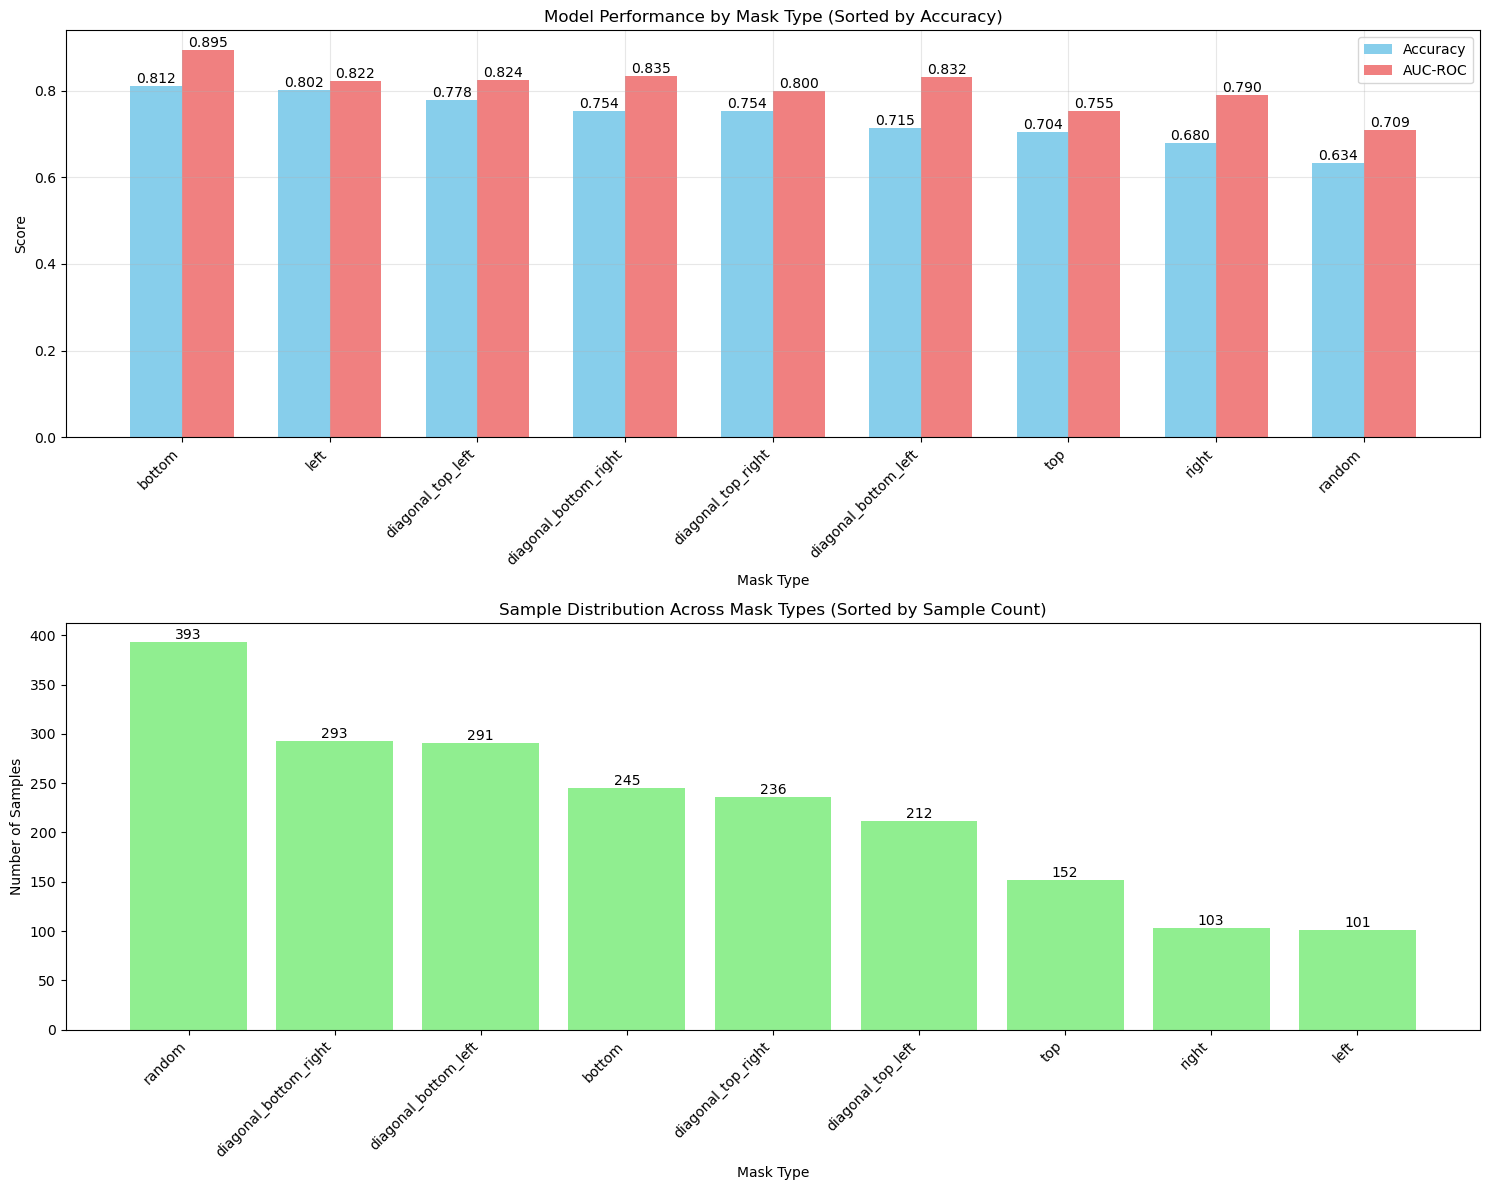

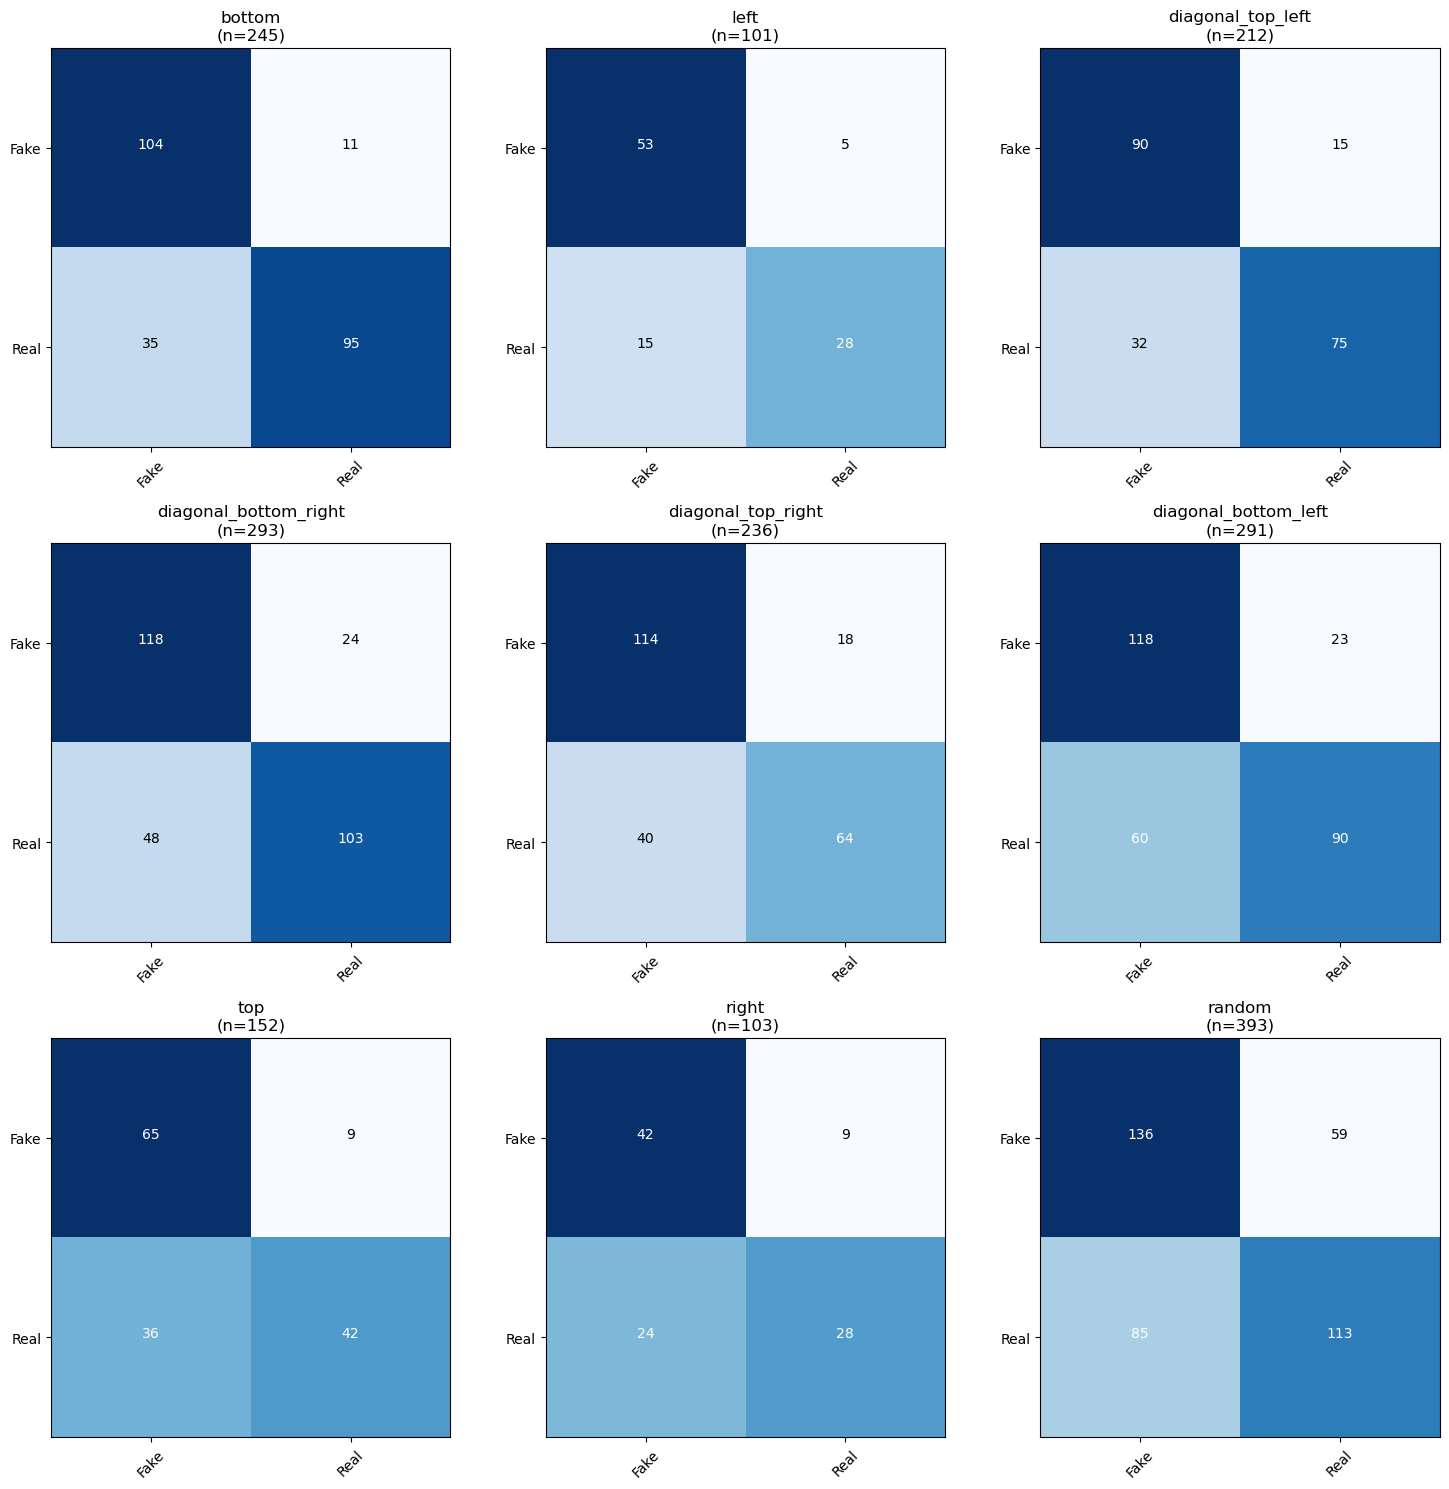

In [39]:
# Run the analysis
results = analyze_performance_by_mask(model, test_paths, test_labels, test_generator)

# Plot the visualizations
plot_mask_type_results(results)

In [36]:
import pandas as pd

def create_performance_metrics_table(results):
    """
    Create a table showing accuracy, precision, recall, and F1-score for each mask type
    """
    metrics = {
        'Mask Type': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1-score': [],
        'Total Samples': []
    }
    
    # Collect metrics for each mask type
    for mask_type, data in results.items():
        report = data['classification_report']
        
        metrics['Mask Type'].append(mask_type)
        metrics['Accuracy'].append(data['accuracy'])
        # Use macro average for overall precision, recall, and F1
        metrics['Precision'].append(report['macro avg']['precision'])
        metrics['Recall'].append(report['macro avg']['recall'])
        metrics['F1-score'].append(report['macro avg']['f1-score'])
        metrics['Total Samples'].append(data['num_samples'])
    
    # Create DataFrame
    df = pd.DataFrame(metrics).set_index('Mask Type')
    
    # Sort by accuracy
    df = df.sort_values('Accuracy', ascending=False)
    
    # Format numbers
    df['Accuracy'] = df['Accuracy'].map('{:.4f}'.format)
    df['Precision'] = df['Precision'].map('{:.4f}'.format)
    df['Recall'] = df['Recall'].map('{:.4f}'.format)
    df['F1-score'] = df['F1-score'].map('{:.4f}'.format)
    df['Total Samples'] = df['Total Samples'].map('{:d}'.format)
    
    return df

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.precision', 4)

# Create and display the table
df = create_performance_metrics_table(results)
print("\n=== Overall Performance Metrics by Mask Type ===")
print(df)


=== Overall Performance Metrics by Mask Type ===
                      Accuracy Precision  Recall F1-score Total Samples
Mask Type                                                              
bottom                  0.8122    0.8222  0.8176   0.8120           245
left                    0.8020    0.8139  0.7825   0.7891           101
diagonal_top_left       0.7783    0.7855  0.7790   0.7772           212
diagonal_bottom_right   0.7543    0.7609  0.7566   0.7536           293
diagonal_top_right      0.7542    0.7604  0.7395   0.7427           236
diagonal_bottom_left    0.7148    0.7297  0.7184   0.7121           291
top                     0.7039    0.7335  0.7084   0.6970           152
right                   0.6796    0.6966  0.6810   0.6736           103
random                  0.6336    0.6362  0.6341   0.6323           393


1/1 [==============================] - 0s 27ms/step


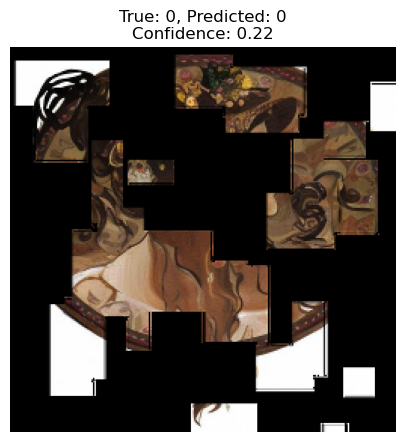

1/1 [==============================] - 0s 28ms/step


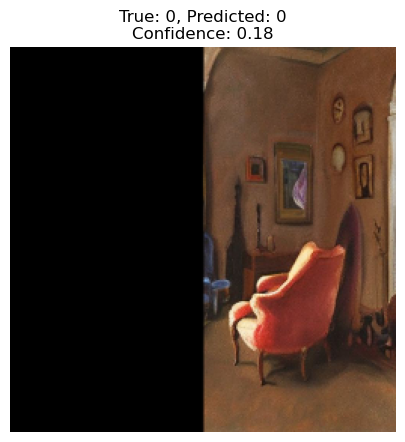

1/1 [==============================] - 0s 21ms/step


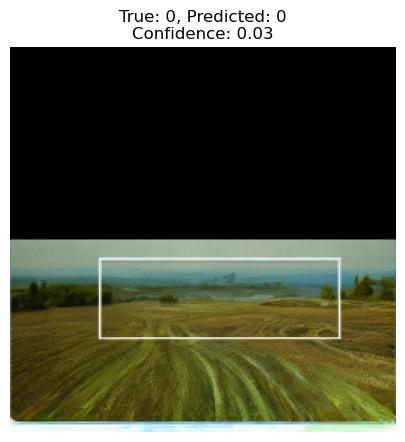

1/1 [==============================] - 0s 22ms/step


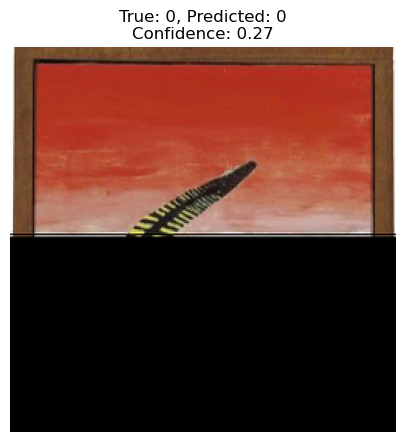

1/1 [==============================] - 0s 26ms/step


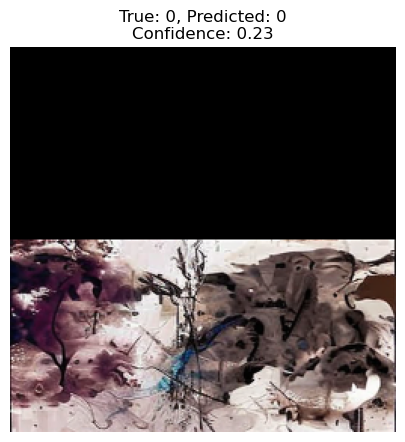

1/1 [==============================] - 0s 22ms/step


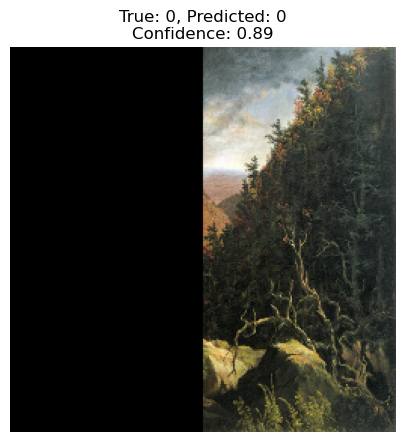

1/1 [==============================] - 0s 26ms/step


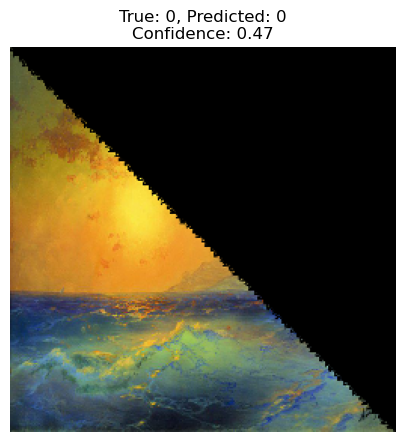

1/1 [==============================] - 0s 19ms/step


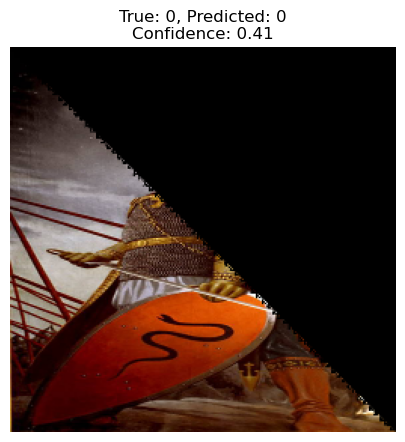

1/1 [==============================] - 0s 27ms/step


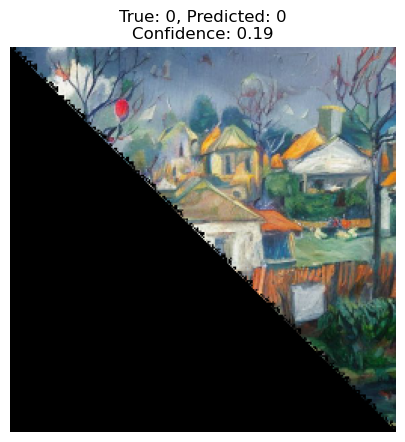

1/1 [==============================] - 0s 23ms/step


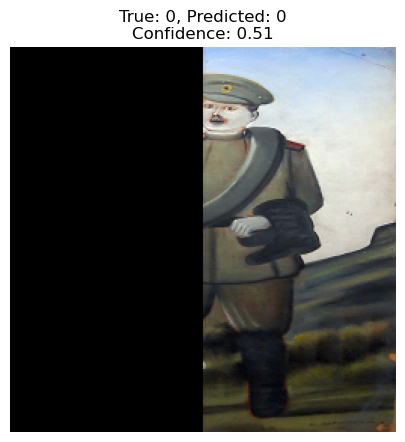

1/1 [==============================] - 0s 24ms/step


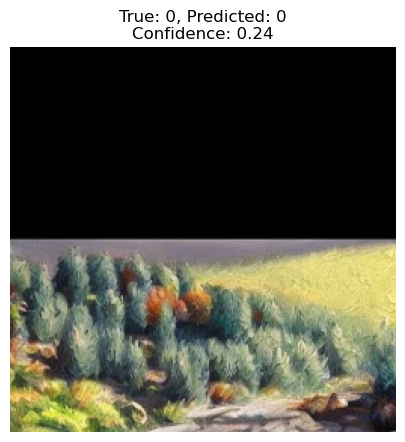

1/1 [==============================] - 0s 20ms/step


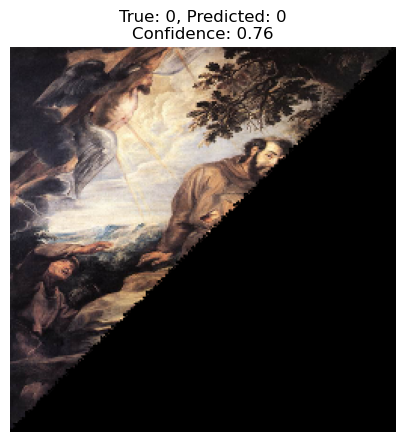

1/1 [==============================] - 0s 22ms/step


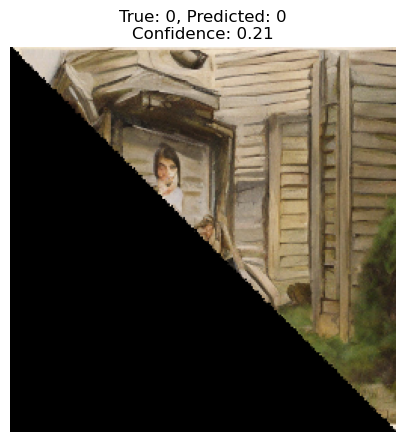

1/1 [==============================] - 0s 23ms/step


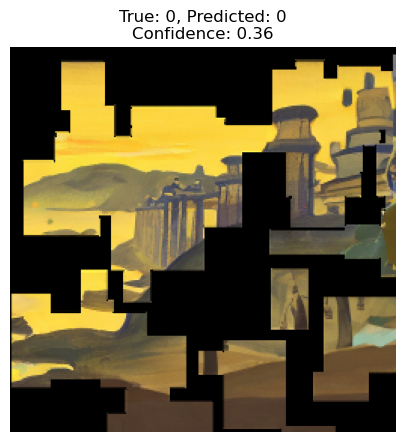

1/1 [==============================] - 0s 24ms/step


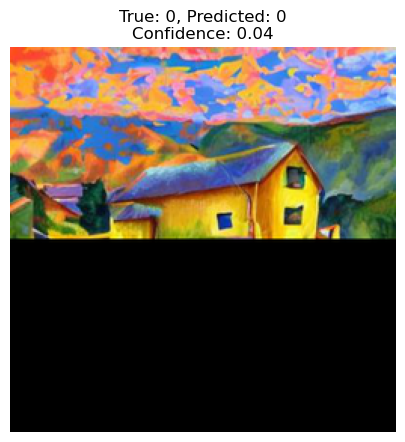

In [41]:
def visualize_predictions(model, test_paths, test_labels, num_samples=15):
    # Randomly select samples
    indices = np.random.choice(len(test_paths), num_samples, replace=False)
    
    for idx in indices:
        # Load and preprocess the image
        img = load_and_preprocess_image(test_paths[idx])
        img_batch = np.expand_dims(img, axis=0)
        
        # Make prediction
        prediction = model.predict(img_batch)[0]
        predicted_class = np.argmax(prediction)
        true_class = np.argmax(test_labels[idx])
        
        # Display the image and prediction
        plt.figure(figsize=(10, 5))
        plt.imshow(img)
        plt.title(f"True: {true_class}, Predicted: {predicted_class}\nConfidence: {prediction[predicted_class]:.2f}")
        plt.axis('off')
        plt.show()

# Call the function
visualize_predictions(model, test_paths, test_labels)